# Preparing data for a multisession `lfads-torch` model

## Objective

Experiments in neuroscience are often repeated across multiple sessions, with different neurons recorded in each session. The multisession LFADS model uses per-session linear readin and readout layers to model datasets across multiple sessions (also known as "stitching"). Importantly, these adapter layers must be initialized using weights obtained by principal components regression (PCR). This initialization aligns the session data into a shared latent space, making it more likely that LFADS will learn shared latent dynamics. This notebook demonstrates how to perform PCR to obtain initialization weights and run multisession LFADS on your datasets. You can find more detail on this method in [1].

## Dataset background

In this example, we use a dataset provided by Adam G. Rouse's Lab at the University of Kansas. The dataset was collected from the primary motor cortex (M1) of an adult, male rhesus macaque (P) performing a precison center-out task using a joystick. The precision task required the subject to single handedly manipulate the joystick moving the displayed cursor from the center into an indicated goal area. The goal areas were spaced equidistant from each other in 45° increments, and designed to be narrow and deep, wide and shallow, or wide and deep. The precision center-out task utilized small targets and a required hold time to elicit not only initial center-out reaches but also corrective movements. After reaching the goal area, the animals were required to hold for 500-600 ms. If the cursor left the goal area within the hold interval, the animal was allowed to to move and re-enter the goal as many times as required to complete a successful hold. These are called the corrective movements. Animals were provided a liquid reward upon successful trial completion. The experiment was repeated for 12 sessions over a period of 2 months. The dataset was used in works [2-4], and is made available for download at [5].

[1] Pandarinath, et al., "Inferring single-trial neural population dynamics using sequential auto-encoders." (2018) Nature Methods.

[2] Rouse, et al., "Cyclic, condition-independent activity in primary motor cortex predicts corrective movement behavior." (2022) eNeuro.

[3] Lee^✝^, Karpowicz^✝^, et al., "Identifying distinct neural features between the initial and corrective phases of precise reaching using AutoLFADS." (2023) bioRxiv.

[4] Schwartze, et al., "Initial and corrective submovement encoding differences within primary motor cortex during precision reaching." (2023) bioRxiv.

[5] Processed data files used in Lee*, Karpowicz*, et al., 2023: https://doi.org/10.6084/m9.figshare.24520957

In [1]:
%load_ext autoreload
%autoreload 2

## Downloading the data
To start, download the `AnimalP.zip` file from the [FigShare repo](https://doi.org/10.6084/m9.figshare.24520957). This file contains 12 `.mat` files-- one for recording session. Unzip the file and place the `AnimalP` folder in in the same directory as this notebook. The following cell should list the names of the session files.

In [2]:
from glob import glob

DATA_PATHS = sorted(glob("AnimalP/P_Spikes_*-data_PSTH_prep_bin_20.mat"))
DATA_PATHS

['AnimalP/P_Spikes_20170630-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170703-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170705-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170706-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170712-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170713-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170714-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170717-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170720-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170731-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170801-data_PSTH_prep_bin_20.mat',
 'AnimalP/P_Spikes_20170802-data_PSTH_prep_bin_20.mat']

# Loading the data from each session
To compute the PCR initializations, we first need to compute PSTHs for each session. The continuous spiking data from these recording sessions has already been aligned and binned into arrays of shape `n_neurons x n_timepoints x n_trials` (`spikes_peakVel`). The relevant code can be found in the FigShare repo. The condition labels are of shape `n_trials` (`conditionID_peakVel`).

In [3]:
import re
from scipy.io import loadmat

# Data is binned at 20 ms
bin_width_sec = 0.02
spikes = {}
conds = {}
# Regex matches the dates in the file names
date_regex = re.compile(r"(2017\d{4})")
for data_path in DATA_PATHS:
    session = date_regex.findall(data_path)[0]
    data = loadmat(data_path)
    spikes[session] = data["spikes_peakVel"].swapaxes(0, 2) * bin_width_sec
    conds[session] = data["conditionID_peakVel"].squeeze() - 1
{sess: s.shape for sess, s in spikes.items()}

{'20170630': (1575, 30, 113),
 '20170703': (1847, 30, 122),
 '20170705': (1707, 30, 133),
 '20170706': (1226, 30, 108),
 '20170712': (1164, 30, 104),
 '20170713': (1522, 30, 97),
 '20170714': (1335, 30, 124),
 '20170717': (1299, 30, 87),
 '20170720': (1575, 30, 94),
 '20170731': (1276, 30, 96),
 '20170801': (1392, 30, 122),
 '20170802': (1523, 30, 93)}

# Removing any trials with missing values
Missing values in the spike arrays will cause problems when calculating PSTHs, so let's get rid of trials with any |missing values.

In [4]:
import numpy as np

for session in spikes:
    valid_trials = ~np.isnan(spikes[session]).any(axis=(1, 2))
    spikes[session] = spikes[session][valid_trials]
    conds[session] = conds[session][valid_trials]
{sess: s.shape for sess, s in spikes.items()}

{'20170630': (1575, 30, 113),
 '20170703': (1847, 30, 122),
 '20170705': (1707, 30, 133),
 '20170706': (1226, 30, 108),
 '20170712': (1164, 30, 104),
 '20170713': (1522, 30, 97),
 '20170714': (1331, 30, 124),
 '20170717': (1296, 30, 87),
 '20170720': (1569, 30, 94),
 '20170731': (1276, 30, 96),
 '20170801': (1386, 30, 122),
 '20170802': (1523, 30, 93)}

# Smoothing spikes by convolving with a Gaussian kernel

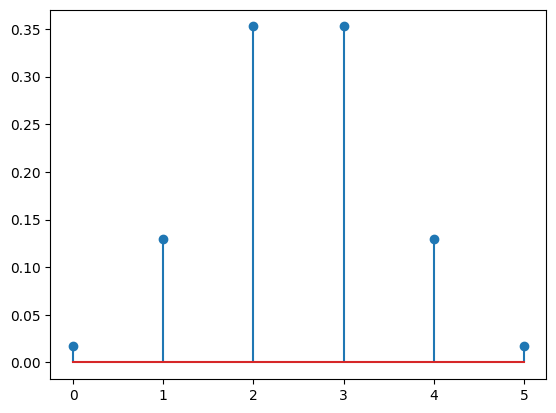

In [5]:
from scipy.signal.windows import gaussian
import matplotlib.pyplot as plt

std_sec = 0.02
# Scale the width of the Gaussian by our bin width
std = std_sec / bin_width_sec
# We need a window length of 3 standard deviations on each side (x2)
M = std * 3 * 2
window = gaussian(M, std)
# Normalize so the window sums to 1
window = window / window.sum()
_ = plt.stem(window)

In [6]:
from scipy.signal import lfilter

# Remove convolution artifacts
invalid_len = len(window) // 2

smth_spikes = {}
for session in spikes:
    # Convolve each session with the gaussian window (10s); previously 2m15s
    smth_spikes[session] = lfilter(window, 1, spikes[session], axis=1)[:, invalid_len:, :]

# Computing PSTHs by averaging within conditions

In [7]:
psths = {}
for session in spikes:
    sess_smth_spikes = smth_spikes[session]
    sess_conds = conds[session]
    sess_psths = []
    for cond in np.unique(sess_conds):
        psth = np.mean(sess_smth_spikes[sess_conds == cond], axis=0)
        sess_psths.append(psth)
    psths[session] = np.array(sess_psths)
{sess: p.shape for sess, p in psths.items()}

{'20170630': (32, 27, 113),
 '20170703': (32, 27, 122),
 '20170705': (32, 27, 133),
 '20170706': (32, 27, 108),
 '20170712': (32, 27, 104),
 '20170713': (32, 27, 97),
 '20170714': (32, 27, 124),
 '20170717': (32, 27, 87),
 '20170720': (32, 27, 94),
 '20170731': (32, 27, 96),
 '20170801': (32, 27, 122),
 '20170802': (32, 27, 93)}

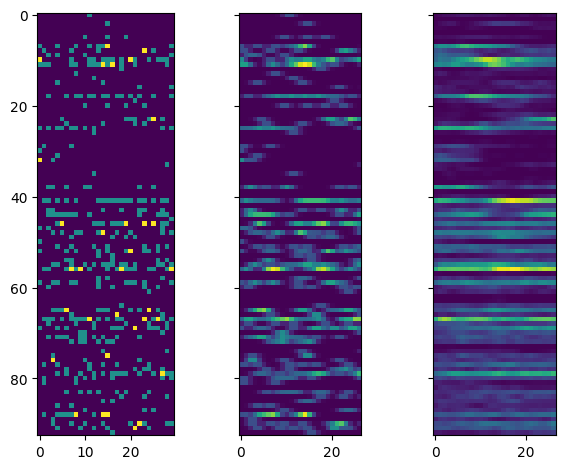

In [8]:
# Visualize raw spikes, smoothed spikes, and PSTHs
condition = 0
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
_ = ax1.imshow(spikes[session][conds[session] == condition][0].T)
_ = ax2.imshow(smth_spikes[session][conds[session] == condition][0].T)
_ = ax3.imshow(psths[session][condition].T)
plt.tight_layout()

# Principal Components Regression (PCR)

To stitch multiple sessions into a common dynamical model, LFADS is configured to use per-session “read-in” matrices, mapping from observed spiking to input factors, as well as per-session “read-out” matrices, mapping from factors to neuron rates. The shape of these matrices can vary to match the number of neural channels recorded in each dataset. Importantly, a single encoder, generator, and factor matrix are shared across sessions and learned jointly from all sessions. The per-session read-in and read-out matrices are learned using data from only the corresponding session. 

We initialize the weights of the read-in and read-out matrices using Principal Components Regression (PCR). PCR maps the trial-averaged firing rates from each individual session to the shared principal components across all sessions. This provides the model with an input that is already in a shared subspace and is critical for ensuring a shared set of dynamics is learned.

First the trial-averages across all sessions are reshaped into an array of shape `(n_timepoints * n_conditions) x (n_sessions * n_neurons)` and PCA is computed to find the "global" PCs across all the sessions. Next, each session's trial-averages are mapped to this global space using a Ridge regression model and the corresponding weights and biases from the trained model are saved to be used as the readin weights and biases in the model.

In [9]:
sessions = sorted(spikes.keys())
combined_psths = np.concatenate([psths[s] for s in sessions], axis=-1)
combined_psths = combined_psths.reshape(-1, combined_psths.shape[-1])
print(combined_psths.shape)

(864, 1293)


Now we will plot the concatenated trial averages to verify if the data is reshaped correctly. Since all the conditions are concatenated together,
you should see a separated block of activity for each condition. Here, this will present as 32 distinct "columns" in the data.

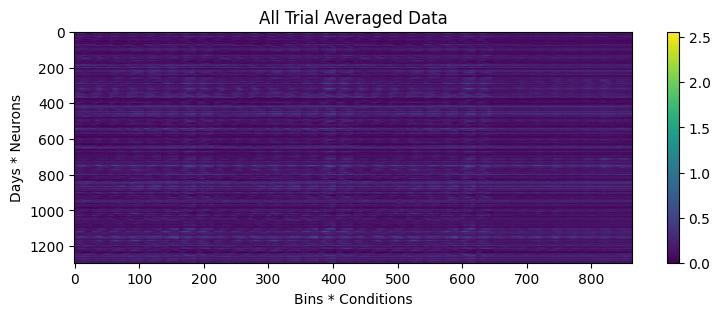

In [10]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.imshow(combined_psths.T)
plt.colorbar()
ax.set_aspect('auto')
plt.xlabel('Bins * Conditions')
plt.ylabel('Days * Neurons')
plt.title('All Trial Averaged Data')
plt.show()

Now, let's compute the global PCs and plot the variance explained by each PC. We find the number of PCs needed to explain 90% of the variance and update the n_pcs parameter
accordingly. Usually, 50 PCs are enough to explain 90% of the variance for the current dataset.

43 PCs needed to explain 90% of variance.


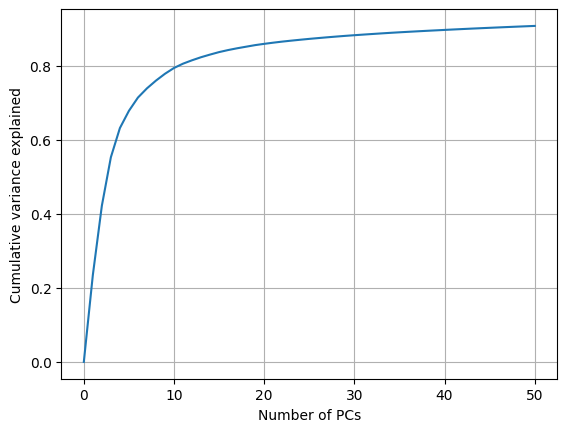

In [11]:
from sklearn.decomposition import PCA

n_components = 50
# Perform PCA on mean-centered data
combined_psths_ctrd = combined_psths - np.mean(combined_psths, axis=0)
pca = PCA(n_components).fit(combined_psths_ctrd)
combined_psth_pcs = pca.transform(combined_psths_ctrd)
# Plot the cumulative variance explained
cumvar_expl = np.concatenate([[0], np.cumsum(pca.explained_variance_ratio_)])
print(f"{np.where(cumvar_expl > 0.9)[0][0]} PCs needed to explain 90% of variance.")
plt.plot(cumvar_expl)
plt.grid()
plt.xlabel("Number of PCs")
_ = plt.ylabel("Cumulative variance explained")

Now, let's plot the first three PCs of the global space. You should see a clear separation of the conditions in the first three PCs.

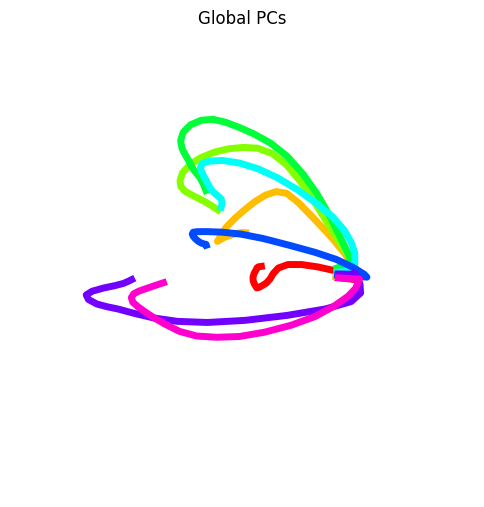

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create a 3D plotting axis
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(projection='3d')
# Reorganize the PCs for plotting
n_conds, n_timesteps, _ = psths[session].shape
psth_pcs = np.reshape(combined_psth_pcs, (n_conds, n_timesteps, n_components))
# Plot according to reach direction
conditions = np.unique(conds[session]) % 8
unique_conds = np.unique(conditions)
for c in unique_conds:
    avg_psth = np.mean(psth_pcs[conditions == c], axis=0)
    ax.plot(
        *avg_psth.T[:3],
        color=cm.hsv(c / len(unique_conds)),
        linewidth=5,
    )
ax.view_init(elev=30, azim=30, roll=0)
ax.set_title('Global PCs')
_ = ax.axis('off')

Here we run PCR to get alignment matrices, biases, and PCs for each session. The output is a dict of length n_sessions. 

In [13]:
from sklearn.linear_model import Ridge

latents = {}
weights = {}
biases = {}
for session in spikes:
    model = Ridge(alpha=1.0, fit_intercept=False, random_state=42)
    data = psths[session].reshape(-1, psths[session].shape[-1])
    data_means = data.mean(axis=0)
    data_ctrd = data - data_means
    model.fit(data_ctrd, combined_psth_pcs)
    latents[session] = model.predict(data_ctrd).reshape((n_conds, n_timesteps, n_components))
    weights[session] = model.coef_.T
    biases[session] = data_means
{sess: w.shape for sess, w in weights.items()}

{'20170630': (113, 50),
 '20170703': (122, 50),
 '20170705': (133, 50),
 '20170706': (108, 50),
 '20170712': (104, 50),
 '20170713': (97, 50),
 '20170714': (124, 50),
 '20170717': (87, 50),
 '20170720': (94, 50),
 '20170731': (96, 50),
 '20170801': (122, 50),
 '20170802': (93, 50)}

Let's plot the first three PCs of the local space for each session. All the sessions' PC spaces should look similar to each other and to the global space. 

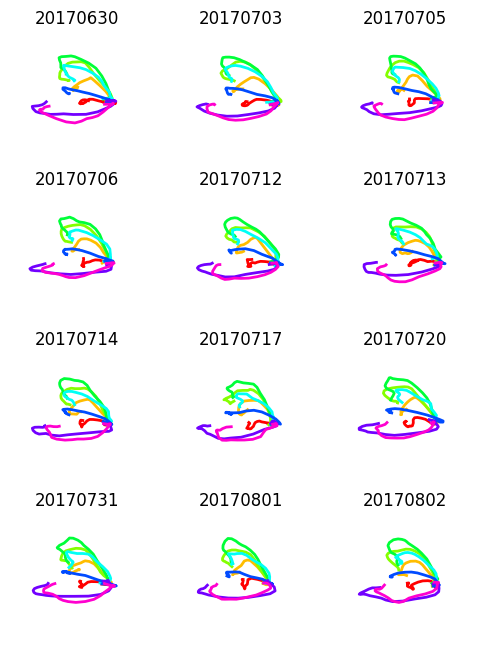

In [14]:
# Create an array of 3D axes
fig = plt.figure(figsize=(6, 8))
nrows, ncols = 4, 3
axes = []
for i in range(nrows * ncols):
    axes.append(fig.add_subplot(nrows, ncols, i + 1, projection="3d"))
# Plot the latent factors for each session
for i, sess in enumerate(sessions):
    for c in unique_conds:
        avg_latents = np.mean(latents[sess][conditions == c], axis=0)
        axes[i].plot(
            *avg_latents.T[:3],
            color=cm.hsv(c / len(unique_conds)),
            linewidth=2,
        )
    axes[i].view_init(elev=30, azim=30)
    axes[i].axis('off')
    axes[i].set_title(sess)

# Saving the data for `lfads-torch`
Now let's organize and save the data with their alignment matrices and biases for each session to run in an lfads-torch model.

Each session is saved as a separate .h5 file. The data is saved in the following format:

- `train_encod_data`: Data to be used as input when training the model.
- `train_recon_data`: Data to be used as a reconstruction target when training the model.
- `valid_encod_data`: Data to be used as input when validating the model.
- `valid_recon_data`: Data to be used as a reconstruction target when validating the model.
- `readin_weight`: Alignment matrix from PCR for each session
- `readout_bias`: Alignment bias from PCR for each session

In [15]:
import os
import h5py

data_dir = "../../datasets/rouse_multisession"
os.makedirs(data_dir, exist_ok=True)
for sess in sessions:
    # Assign every 5th trial (20%) to the validation set
    sess_spikes = spikes[sess]
    train_inds, valid_inds = [], []
    for i in range(len(sess_spikes)):
        if (i % 5) == 0:
            valid_inds.append(i)
        else:
            train_inds.append(i)
    train_inds = np.array(train_inds)
    valid_inds = np.array(valid_inds)
    # Write the data for each session to its own file
    kwargs = dict(dtype='float32', compression='gzip')
    with h5py.File(f"{data_dir}/lfads_{sess}.h5", 'w') as h5f:
        h5f.create_dataset('train_encod_data', data=sess_spikes[train_inds], **kwargs)
        h5f.create_dataset('valid_encod_data', data=sess_spikes[valid_inds], **kwargs)
        h5f.create_dataset('train_recon_data', data=sess_spikes[train_inds], **kwargs)
        h5f.create_dataset('valid_recon_data', data=sess_spikes[valid_inds], **kwargs)
        h5f.create_dataset('readin_weight', data=weights[sess], **kwargs)
        h5f.create_dataset('readout_bias', data=biases[sess], **kwargs)

# Training `lfads-torch`

Now that we have prepared the dataset for running multisession with lfads-torch, let's go through the process of training the model on the prepared dataset. 
1. If you haven't already, clone the [lfads-torch repository](https://github.com/arsedler9/lfads-torch) and follow the installation instructions in the README. 
1. To run the lfads-torch model, you'll need to create datamodule and model configuration files. You can find samples of multisession config files for the current dataset in `configs/datamodule/rouse_multisession_PCR.yaml` and `configs/model/rouse_multisession_PCR.yaml`.
1. If you want the number of PCs to be the same as the number of factors, you can use the `MultisessionReadout` module with default arguments. The readout matrix will be initialized as the pseudoinverse of the readin matrix (Example: `configs/model/rouse_multisession_PCR.yaml`).
1. If you want the number of factors to be different from the number of PCs, you can use the `MultisessionReadout` and set `out_features` to `fac_dim` and `pcr_init` to `False`. The readout matrix will be randomly initialized (Example: `configs/model/rouse_multisession_random.yaml`).
1. Change the datamodule and model parameters in `scripts/run_pbt.py`. Finally, run `scripts/run_pbt.py` to start training the model. 